
# **Calculating WMD and Cosine Score for JSTOR Article Samples**



Computational Literature Review

Creator: Nancy Xu

Date created: September 6, 2022

Date last modified: September 14, 2022

This notebook:
- generates 20 samples of articles in positive/negative classes for each of the 3 perspectives
- calculates Word Mover's Distance (using a gensim Word2Vec model) between an article and core seed terms
- calculates cosine similarity between an article (represented by a Doc2Vec embedding) and average vector of core seed terms (represented by a Word2Vec embedding)
- compares the distribution of WMD scores and cosine similarity scores for each positive/negative perspective

In [ ]:
import pandas as pd
import gensim
import pickle
import os
import re
import ast
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from sklearn import utils
cores = multiprocessing.cpu_count()
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from numpy import dot, absolute
from numpy.linalg import norm

## Text preprocessing & train phrased Word2Vec model

Load in and preprocess dataframes for each perspective.

In [ ]:
os.chdir('/home/jovyan/work/models_storage/preprocessed_texts')
def open_test_data(path):
    return open(path, 'rb')
with open_test_data('training_relational_preprocessed_100321.pkl') as f:
    rela = pickle.load(f)

with open_test_data('training_demographic_preprocessed_100321.pkl') as f:
    demog = pickle.load(f)

with open_test_data('training_orgs_preprocessed_100321.pkl') as f:
    orgs = pickle.load(f)

with open_test_data('training_cultural_preprocessed_100321.pkl') as f:
    cult = pickle.load(f)
    

import itertools
full_text = []

for i in cult['text']:
    joined = list(itertools.chain(*i))
    full_text.append(" ".join(joined))

full_text_demog = []
for i in demog['text']:
    joined = list(itertools.chain(*i))
    full_text_demog.append(" ".join(joined))

full_text_orgs = []
for j in orgs['text']:
    joined = list(itertools.chain(*j))
    full_text_orgs.append(" ".join(joined))

full_text_rela = []
for j in rela['text']:
    joined = list(itertools.chain(*j))
    full_text_rela.append(" ".join(joined))

cult['full_text'] = full_text
demog['full_text'] = full_text_demog
orgs['full_text'] = full_text_orgs
rela['full_text'] = full_text_rela

def remove_tags(article):
    article = re.sub('<plain_text> <page sequence="1">', '', article)
    article = re.sub(r'</page>(\<.*?\>)', ' \n ', article)
    # xml tags
    article = re.sub(r'<.*?>', '', article)
    article = re.sub(r'<body.*\n\s*.*\s*.*>', '', article)
    return article

tags_removed = [remove_tags(art) for art in cult['full_text']]
tags_removed_demog = [remove_tags(art) for art in demog['full_text']]
tags_removed_org = [remove_tags(art) for art in orgs['full_text']]
tags_removed_rela = [remove_tags(art) for art in rela['full_text']]
cult['text_no_tags'] = tags_removed
demog['text_no_tags'] = tags_removed_demog
orgs['text_no_tags'] = tags_removed_org
rela['text_no_tags'] = tags_removed_rela

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['one', 'two', 'three', 'amp', 'may', 'can', 'new', 'also', 'and'])

import string
import re
import nltk

def word_process(tt):
    """
    helper function to lower text, remove stop words, numbers, and empty 
    """
    
    tt = tt.lower()
    
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~=\n'''
    # Removing punctuations in string 
    # Using loop + punctuation string 


    for ele in tt:  
        if ele in punc:  
            tt = tt.replace(ele, " ")  

    # read tokens
    tokens = tt.split()
    lst = [token.translate(punc).lower() for token in tokens ]
    
    #remove stop words
    filtered = []
    for i in lst:
        if i not in stop_words:
            filtered.append(i)
    
    # removing singular numbers and singular letters
    pattern = '[0-9]'
    filtered = [re.sub(pattern, '', i) for i in filtered] 
    new = []
    for inp in filtered:
        new.append(' '.join( [w for w in inp.split() if len(w)>1] ))
        
    # filter out empty strings 
    new = [i for i in new if i] 

    dt = [d.split() for d in new]
    
  
    st = ''
    for i in dt:
        st = st + " " + i[0]
    return st
    

cult['processed']  =  cult['text_no_tags'].apply(word_process)
rela['processed']  =  rela['text_no_tags'].apply(word_process)
demog['processed']  =  demog['text_no_tags'].apply(word_process)
orgs['processed']  =  orgs['text_no_tags'].apply(word_process)

cult_pos = cult[cult['cultural_score']==1]
cult_neg = cult[cult['cultural_score']==0]

rela_pos = rela[rela['relational_score']==1]
rela_neg = rela[rela['relational_score']==0]

demog_pos = demog[demog['demographic_score']==1]
demog_neg = demog[demog['demographic_score']==0]

pos_cult = cult_pos.sample(20, replace = False)
neg_cult = cult_neg.sample(20, replace = False)

pos_rela = rela_pos.sample(20, replace = False)
neg_rela = rela_neg.sample(20, replace = False)

pos_demog = demog_pos.sample(20, replace = False)
neg_demog = demog_neg.sample(20, replace = False)

pos_cult.to_csv('/home/jovyan/work/nancyxu/pos_cult.csv')
neg_cult.to_csv('/home/jovyan/work/nancyxu/neg_cult.csv')
pos_rela.to_csv('/home/jovyan/work/nancyxu/pos_rela.csv')
neg_rela.to_csv('/home/jovyan/work/nancyxu/neg_rela.csv')
pos_demog.to_csv('/home/jovyan/work/nancyxu/pos_demog.csv')
neg_demog.to_csv('/home/jovyan/work/nancyxu/neg_demog.csv')


In [ ]:

pos_cult = pd.read_csv('pos_cult.csv')
neg_cult = pd.read_csv('neg_cult.csv')
pos_rela = pd.read_csv('pos_rela.csv')
neg_rela = pd.read_csv('neg_rela.csv')
pos_demog = pd.read_csv('pos_demog.csv')
neg_demog = pd.read_csv('neg_demog.csv')


In [ ]:
## get dataframe with all articles belong to the 3 perspectives 
df = pd.concat([cult_pos,rela_pos,demog_pos])

train w2v model on the positively labeled articles for each perspective.

In [ ]:
df['processed']=[x.strip() for x in df['processed']]

In [ ]:

def build_phrases(sentences):
    phrases = Phrases(sentences, min_count = 5, threshold = 7, progress_per = 1000)
    return Phraser(phrases)

In [ ]:
processed = [x.split() for x in df['processed']]

In [ ]:
bigram = build_phrases(processed)
processed_bigrams = [bigram[i] for i in processed]

In [ ]:
processed_bigrams_final = []
## strip punctuations
for k in processed_bigrams:
    processed_bigrams_final.append([i.strip('!"“#$%&\'()*+,-./:;<=>?@[\\]^`{|}~…') for i in k if len(i)>2])


In [ ]:
w2v = Word2Vec(processed_bigrams_final, size = 300, window = 10,
                                       min_count = 5, sg = 1, alpha = 0.05,
                                       batch_words = 10000, workers = cores, seed = 0, negative = 5,ns_exponent = 0.75)

In [ ]:
w2v.save('w2v_914')

In [ ]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [ ]:
# import numpy as np
# def find_mean_and_closest_article(article,df,topk):
#     """
#     calcalate the mean wmd of a certain article from other articles in the same perspective,
#     then give the top k closest articles in the same perspective.
#     """
#     d = []
#     for i in np.arange(len(df)):
#         d.append(calc_wmd(article,df.loc[i,'processed']))
#     dis_dict = pd.DataFrame(list(zip(d,df['processed'])), columns = ['distance', 'article'])
#     dis_dict['full_text'] = df['full_text']
#     dis_dict['edited_filename'] = df['edited_filename'] 
#     dis_dict = dis_dict[dis_dict['article']!=article]
#     srted = dis_dict.sort_values('distance').head(topk)

#     return np.mean(dis_dict['distance']), tuple(zip(srted['edited_filename'], srted['distance']))
        
# def get_cols_sims(df):
#     """
#     get mean wmd similarity scores 
#     """
#     results = pos_cult['processed'].apply(lambda x: find_closest_article(x,pos_cult,10))
#     mean_sims_score = [i[0] for i in results]
#     top10_sims_articles = [i[1] for i in results]
#     df['mean_sims_score'] = mean_sims_score
#     df['top10_sims_articles'] = top10_sims_articles
#     return df.sort_values('mean_sims_score')

## Compute WMD between an article and perspective seed terms

reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html

In [ ]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [ ]:
def read_txt_lst(file):
    txt_file = open(file, "r")
    file_content = txt_file.read()
    # print("The file content are: ", file_content)

    content_list = file_content.split("\n")
    txt_file.close()
    return content_list

In [ ]:
dem_core=read_txt_lst('demographic_core.txt')
rela_core=read_txt_lst('relational_core.txt')
cult_core = read_txt_lst('cultural_core.txt')

In [ ]:
dem_core=[re.sub(r'\s','_',x) for x in dem_core]
rela_core=[re.sub(r'\s','_',x) for x in rela_core]
cult_core=[re.sub(r'\s','_',x) for x in cult_core]

In [ ]:
def get_sims_with_perspective(article):
  """
  get wmd similarity between this article and the core terms of each perspective
  """

  ## first build bigram from the article

  ss = [article.split()]
  bb = build_phrases(ss)
  pb = [bb[i] for i in ss][0]

  dem_score = calc_wmd(pb,(dem_core))
  rela_score = calc_wmd(pb,(rela_core))
  cult_score = calc_wmd(pb,(cult_core))
  return (dem_score,rela_score,cult_score)

In [ ]:
get_sims_with_perspective(pos_cult.loc[0,'processed'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


(5.42637915870871, 5.232177314039429, 5.237167382138559)

In [ ]:
get_sims_with_perspective(pos_rela.loc[0,'processed'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


(5.511709636011158, 5.235622040175475, 5.398345213885615)

In [ ]:

def get_sim_perspective(df):

    """
    returns modified df with extra columns dem_score,rela_score,cult_score
    denoting the wmd score calculated for each article.
    """
    tqdm.pandas()

    results=df['processed'].apply(lambda x:get_sims_with_perspective(x))
    dem_scores = [i[0] for i in results]
    rela_scores = [i[1] for i in results]
    cult_scores = [i[2] for i in results]
    df['dem_scores'] = dem_scores
    df['rela_scores'] = rela_scores
    df['cult_scores']= cult_scores
    return df

In [ ]:
pos_cult = get_sim_perspective(pos_cult)
neg_cult = get_sim_perspective(neg_cult)

pos_demog = get_sim_perspective(pos_demog)
neg_demog = get_sim_perspective(neg_demog)

pos_rela = get_sim_perspective(pos_rela)
neg_rela = get_sim_perspective(neg_rela)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

##Calculate cosine similarity score between the article and each perspective

Using Doc2Vec to get a vector representation of each jstor article, then calculate cosine similarity between the embedding of each article and average w2v vector for each perspective.

reference: https://github.com/h2researchgroup/embeddings/blob/main/preprocessing/cosine_values_calculate_word2vec.py

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['processed'].str.split())]

In [ ]:
d2v = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

In [ ]:
cult_core_embs=[]
for x in cult_core:
  try:
    cult_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
demog_core_embs=[]
for x in dem_core:
  try:
    demog_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
rela_core_embs=[]
for x in rela_core:
  try:
    rela_core_embs.append(w2v.wv[x])
  except:
    pass


In [ ]:
import numpy as np
rela_core_embs_mean = np.mean(rela_core_embs, axis=0)
cult_core_embs_mean = np.mean(cult_core_embs, axis=0)
demog_core_embs_mean = np.mean(demog_core_embs, axis=0)

In [ ]:


def doc_words_cosine(doc):

  """
  doc = str of text
  get cosine similarity scores between the document embedding and average emb of the core terms in each perspective.
  """
  doc_vec = d2v.infer_vector(doc)

  cult_sim = absolute(dot(doc_vec, cult_core_embs_mean)/(norm(doc_vec)*norm(cult_core_embs_mean)))
  rela_sim = absolute(dot(doc_vec, rela_core_embs_mean)/(norm(doc_vec)*norm(rela_core_embs_mean)))
  demog_sim = absolute(dot(doc_vec, demog_core_embs_mean)/(norm(doc_vec)*norm(demog_core_embs_mean)))

  return (demog_sim,rela_sim,cult_sim)

In [ ]:
def apply_doc_words_cosine(df):

  """
  applies doc_words_cosine on the processed texts in each df
  returns modified df with new columns dem_sim,rela_sim,cult_sim
  """

  results=df['processed'].apply(lambda x:doc_words_cosine(x))
  dem_scores = [i[0] for i in results]
  rela_scores = [i[1] for i in results]
  cult_scores = [i[2] for i in results]
  df['dem_sim'] = dem_scores
  df['rela_sim'] = rela_scores
  df['cult_sim']= cult_scores

  return df

In [ ]:
pos_cult = apply_doc_words_cosine(pos_cult)
neg_cult = apply_doc_words_cosine(neg_cult)

pos_demog = apply_doc_words_cosine(pos_demog)
neg_demog = apply_doc_words_cosine(neg_demog)

pos_rela = apply_doc_words_cosine(pos_rela)
neg_rela = apply_doc_words_cosine(neg_rela)

To classify an article with WMD, get the perspective with the smallest distance.

In [ ]:
pos_rela['classified_perspective_wmd']=pos_rela.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_rela['classified_perspective_wmd']=neg_rela.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
pos_cult['classified_perspective_wmd']=pos_cult.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_cult['classified_perspective_wmd']=neg_cult.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
pos_demog['classified_perspective_wmd']=pos_demog.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_demog['classified_perspective_wmd']=neg_demog.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)

In [ ]:
perspective_dict={0:'demographic', 1:'relational', 2:'cultural'}

In [ ]:
pos_rela['classified_perspective_wmd'] = pos_rela['classified_perspective_wmd'].replace(perspective_dict)
neg_rela['classified_perspective_wmd'] = neg_rela['classified_perspective_wmd'].replace(perspective_dict)
pos_cult['classified_perspective_wmd'] = pos_cult['classified_perspective_wmd'].replace(perspective_dict)
neg_cult['classified_perspective_wmd'] = neg_cult['classified_perspective_wmd'].replace(perspective_dict)
pos_demog['classified_perspective_wmd'] = pos_demog['classified_perspective_wmd'].replace(perspective_dict)
neg_demog['classified_perspective_wmd'] = neg_demog['classified_perspective_wmd'].replace(perspective_dict)

To classify an article with cosine similarity, get the perspective with the biggest cosine similarity.

In [ ]:
pos_rela['classified_perspective_cos']=pos_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_rela['classified_perspective_cos']=neg_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_cult['classified_perspective_cos']=pos_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_cult['classified_perspective_cos']=neg_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_demog['classified_perspective_cos']=pos_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_demog['classified_perspective_cos']=neg_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)

In [ ]:
pos_rela['classified_perspective_cos'] = pos_rela['classified_perspective_cos'].replace(perspective_dict)
neg_rela['classified_perspective_cos'] = neg_rela['classified_perspective_cos'].replace(perspective_dict)
pos_cult['classified_perspective_cos'] = pos_cult['classified_perspective_cos'].replace(perspective_dict)
neg_cult['classified_perspective_cos'] = neg_cult['classified_perspective_cos'].replace(perspective_dict)
pos_demog['classified_perspective_cos'] = pos_demog['classified_perspective_cos'].replace(perspective_dict)
neg_demog['classified_perspective_cos'] = neg_demog['classified_perspective_cos'].replace(perspective_dict)

In [ ]:
pos_cult

,Unnamed: 0,text,cultural_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,dem_scores,rela_scores,cult_scores,dem_sim,rela_sim,cult_sim,classified_perspective_wmd,classified_perspective_cos
0,691,"[['Institutional', 'Sources', 'of', 'Practice'...",1.0,Management & Organizational Behavior,10.2307_2667124,Institutional Sources of Practice Variation: S...,Institutional Sources of Practice Variation: S...,Institutional Sources of Practice Variation: S...,institutional sources practice variation staf...,5.426379,5.232177,5.237167,0.040509,0.059071,0.010300,relational,relational
1,119,"[['Autonomy', 'and', 'the', ""Commercializat'io...",1.0,Sociology,10.2307_3518065,Autonomy and the Commercialization of Higher E...,Autonomy and the Commercializat'ion of Higher ...,Autonomy and the Commercializat'ion of Higher ...,autonomy commercializat ion higher education ...,5.490213,5.240339,5.312080,0.019956,0.073942,0.038231,relational,relational
2,570,"[['Bringing', 'Managers', 'into', 'Theories', ...",1.0,Management & Organizational Behavior,10.2307_4135118,Bringing Managers into Theories of Multimarket...,Bringing Managers into Theories of Multimarket...,Bringing Managers into Theories of Multimarket...,bringing managers theories multimarket compet...,5.456102,5.226426,5.391672,0.027158,0.084170,0.018517,relational,relational
3,659,"[['THE', 'DECLINE', 'AND', 'FALL', 'OF', 'THE'...",1.0,Sociology,10.2307_2095931,The Decline and Fall of the Conglomerate Firm ...,THE DECLINE AND FALL OF THE CONGLOMERATE FIRM ...,THE DECLINE AND FALL OF THE CONGLOMERATE FIRM ...,decline fall conglomerate firm deinstitutiona...,5.462405,5.122750,5.339013,0.055892,0.096728,0.022771,relational,relational
4,880,"[['THE', 'ROLE', 'OF', 'INSTITUTIONALIZATION',...",1.0,Sociology,10.2307_2094862,The Role of Institutionalization in Cultural P...,THE ROLE OF INSTITUTIONALIZATION IN CULTURAL P...,THE ROLE OF INSTITUTIONALIZATION IN CULTURAL P...,role institutionalization cultural persistenc...,5.424501,5.243711,5.330189,0.047036,0.049208,0.089978,relational,cultural
5,113,"[['Institutional', 'Isomorphism', 'and', 'Info...",1.0,Sociology,10.2307_3096861,Institutional Isomorphism and Informal Social ...,Institutional Isomorphism and Informal Social ...,Institutional Isomorphism and Informal Social ...,institutional isomorphism informal social con...,5.574269,5.348210,5.351642,0.007691,0.072982,0.042949,relational,relational
6,689,"[['Organization', 'inf""', 'Vol.', 'No.', 'Janu...",1.0,Management & Organizational Behavior,10.2307_27765958,Young and No Money? Never Mind: The Material I...,"Organization inf"" Vol. No. January-February is...","Organization inf"" Vol. No. January-February is...",organization inf vol january february issn ei...,5.414351,5.190310,5.275645,0.004057,0.000891,0.018885,relational,cultural
7,610,"[['CEO', 'Narcissism,', 'Audience', 'Engagemen...",1.0,Management & Organizational Behavior,10.2307_43546650,"CEO Narcissism, Audience Engagement, and Organ...","CEO Narcissism, Audience Engagement and Organi...","CEO Narcissism, Audience Engagement and Organi...",ceo narcissism audience engagement organizati...,5.457953,5.237587,5.352402,0.013073,0.029155,0.099449,relational,cultural
8,916,"[['Organizational', 'Structure', 'and', 'the',...",1.0,Management & Organizational Behavior,10.2307_2392303,Organizational Structure and the Institutional...,Organizational Structure and the Institutional...,Organizational Structure and the Institutional...,organizational structure institutional enviro...,5.510996,5.283928,5.285227,0.079757,0.023204,0.009865,relational,demographic
9,644,"[['Cultures', 'of', 'Culture:', 'This', 'paper...",1.0,Management & Organizational Behavior,10.2307_2392854,"Cultures of Culture: Academics, Practitioners ...",Cultures of Culture: This paper presents metho...,Cultures of Culture: This paper presents metho...,cultures culture paper presents method assess...,5.432191,5.179034,5.262543,0.051659,0.006384,0

In [ ]:
pos_rela

,Unnamed: 0,text,relational_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,dem_scores,rela_scores,cult_scores,dem_sim,rela_sim,cult_sim,classified_perspective_wmd,classified_perspective_cos
0,767,"[['Robust', 'Action', 'and', 'the', 'Rise', 'o...",1.0,Sociology,10.2307_2781822,"Robust Action and the Rise of the Medici, 1400...","Robust Action and the Rise of the Medici, John...","Robust Action and the Rise of the Medici, John...",robust action rise medici john padgett christ...,5.511710,5.235622,5.398345,0.056104,0.044354,0.020747,relational,demographic
1,606,"[['Hitotsubashi', 'Journal', 'of', 'Commerce',...",1.0,Management & Organizational Behavior,10.2307_43295012,A CONCEPTUAL FRAMEWORK OF SOCIAL ENTREPRENEURS...,Hitotsubashi Journal of Commerce and Managemen...,Hitotsubashi Journal of Commerce and Managemen...,hitotsubashi journal commerce management hito...,5.436343,5.143636,5.293934,0.083818,0.005271,0.015737,relational,demographic
2,75,"[['Organizational', 'Approaches', 'to', 'Inequ...",1.0,Sociology,10.2307_25735076,Organizational Approaches to Inequality: Inert...,Organizational Approaches to Inequality: Inert...,Organizational Approaches to Inequality: Inert...,organizational approaches inequality inertia ...,5.452902,5.220748,5.264002,0.033815,0.015493,0.011559,relational,demographic
3,741,"[['BRINGING', 'STRONG', 'TIES', 'BACK', 'IN:',...",1.0,Sociology,10.2307_2657311,"Bringing Strong Ties Back in: Indirect Ties, N...","BRINGING STRONG TIES BACK IN: INDIRECT TIES, N...","BRINGING STRONG TIES BACK IN: INDIRECT TIES, N...",bringing strong ties back indirect ties netwo...,5.577844,5.256953,5.466884,0.081477,0.129933,0.087919,relational,demographic
4,66,"[['thnicities', 'article', 'The', 'Author(),',...",1.0,Sociology,10.2307_23890858,"""White Backlash"", 'Unfairness' and Justificati...","thnicities article The Author(), Reprints and ...","thnicities article The Author(), Reprints and ...",thnicities article author reprints permission...,5.620786,5.417672,5.454789,0.047709,0.025869,0.080882,relational,demographic
5,427,"[['Academy', 'of', 'Management', 'Perspectives...",1.0,Management & Organizational Behavior,10.2307_29764992,Tackling Design Anew: Getting Back to the Hear...,Academy of Management Perspectives November AR...,Academy of Management Perspectives November AR...,academy management perspectives november arti...,5.396819,5.170018,5.206127,0.029961,0.038949,0.071741,relational,demographic
6,272,"[['Interorganization', 'Contagion', 'in', 'Cor...",1.0,Management & Organizational Behavior,10.2307_2393431,Interorganization Contagion in Corporate Phila...,Interorganization Contagion in Corporate Phila...,Interorganization Contagion in Corporate Phila...,interorganization contagion corporate philant...,5.558303,5.296124,5.381954,0.008463,0.020412,0.060866,relational,demographic
7,924,"[['Joint', 'Ventures', 'and', 'Interorganizati...",1.0,Management & Organizational Behavior,10.2307_2391851,Joint Ventures and Interorganizational Interde...,Joint Ventures and Interorganizational Interde...,Joint Ventures and Interorganizational Interde...,joint ventures interorganizational interdepen...,5.501804,4.858861,5.427747,0.075840,0.070776,0.030486,relational,demographic
8,302,"[['Strategic', 'Management', 'Journal,', 'Vol....",1.0,Management & Organizational Behavior,10.2307_2486897,Corporate Governance and the Bankrupt Firm: An...,"Strategic Management Journal, Vol. RESEARCH NO...","Strategic Management Journal, Vol. RESEARCH NO...",strategic management journal vol research not...,5.492804,5.115070,5.395321,0.049956,0.032410,0.006674,relational,demographic
9,768,"[['<body', 'xmlns:mml=""http://www..org//Math/M...",1.0,Sociology,10.1086_661757,Jazz and the Disconnected: City Structural Dis...,"<body xmlns:mml=""http://www..org//Math/MathML""...",The Influence of the Disconnected: Addressing...,influence disconnected addressing theoretical...,5.533154,5.293601,5.419942,0.077171,0.004326,0

In [ ]:
pos_cult.to_csv('pos_cult_sample_wmd_cos.csv')
neg_cult.to_csv('neg_cult_sample_wmd_cos.csv')
pos_demog.to_csv('pos_demog_sample_wmd_cos.csv')
neg_demog.to_csv('neg_demog_sample_wmd_cos.csv')
pos_rela.to_csv('pos_rela_sample_wmd_cos.csv')
neg_rela.to_csv('neg_rela_sample_wmd_cos.csv')

## Inspecting Distribution of Similarity Metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import normalize

#### Overlayed Distributions

- normalize cosine similarity (range 0-1) and wmd (range 4-6) since they are on different scales
- invert the normalized wmd score, since originally the bigger the wmd, the more distant 2 vectors are

**Relational samples**

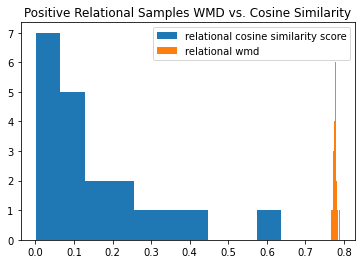

In [ ]:

plt.hist(normalize([pos_rela['rela_sim']])[0], label = 'relational cosine similarity score')
plt.hist(1-normalize([pos_rela['rela_scores']])[0], label = 'relational wmd')
plt.legend(loc='upper right')
plt.title('Positive Relational Samples WMD vs. Cosine Similarity')
plt.show()

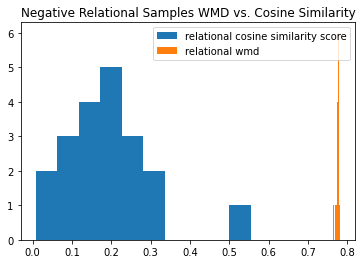

In [ ]:
plt.hist(normalize([neg_rela['rela_sim']])[0], label = 'relational cosine similarity score')
plt.hist(1-normalize([neg_rela['rela_scores']])[0], label = 'relational wmd')
plt.legend(loc='upper right')
plt.title('Negative Relational Samples WMD vs. Cosine Similarity')
plt.show()

**Demographic samples**

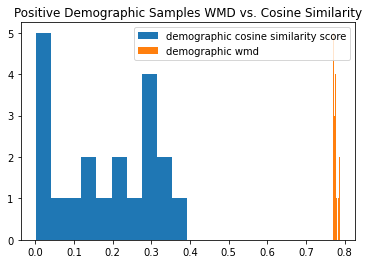

In [ ]:
plt.hist(normalize([pos_demog['dem_sim']])[0], label = 'demographic cosine similarity score')
plt.hist(1-normalize([pos_demog['dem_scores']])[0], label = 'demographic wmd')
plt.legend(loc='upper right')
plt.title('Positive Demographic Samples WMD vs. Cosine Similarity')
plt.show()

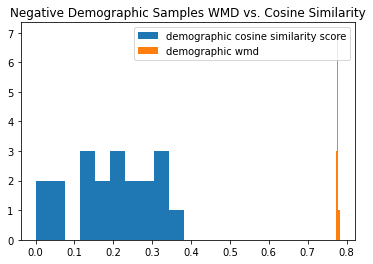

In [ ]:
plt.hist(normalize([neg_demog['dem_sim']])[0], label = 'demographic cosine similarity score')
plt.hist(1-normalize([neg_demog['dem_scores']])[0], label = 'demographic wmd')
plt.legend(loc='upper right')
plt.title('Negative Demographic Samples WMD vs. Cosine Similarity')
plt.show()

**Cultural samples**

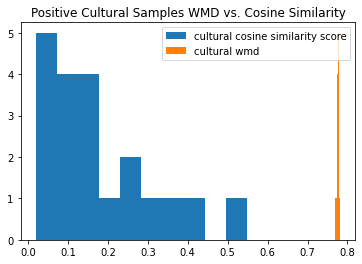

In [ ]:
plt.hist(normalize([pos_cult['cult_sim']])[0], label = 'cultural cosine similarity score')
plt.hist(1-normalize([pos_cult['cult_scores']])[0], label = 'cultural wmd')
plt.legend(loc='upper right')
plt.title('Positive Cultural Samples WMD vs. Cosine Similarity')
plt.show()

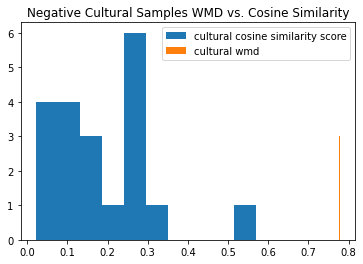

In [ ]:
plt.hist(normalize([neg_cult['cult_sim']])[0], label = 'cultural cosine similarity score')
plt.hist(1-normalize([neg_cult['cult_scores']])[0], label = 'cultural wmd')
plt.legend(loc='upper right')
plt.title('Negative Cultural Samples WMD vs. Cosine Similarity')
plt.show()

Separate Distributions

**Relational samples**

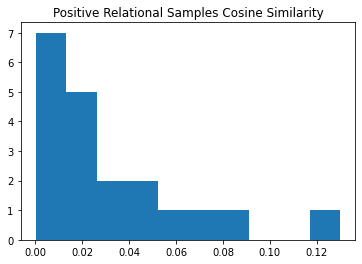

In [ ]:
plt.hist(([pos_rela['rela_sim']]), label = 'relational cosine similarity score')
plt.title('Positive Relational Samples Cosine Similarity')
plt.show()

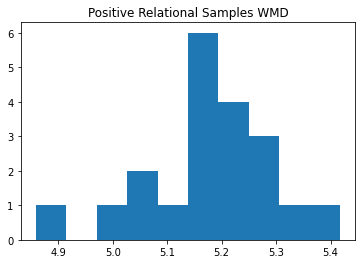

In [ ]:
plt.hist(([pos_rela['rela_scores']]), label = 'relational wmd')
plt.title('Positive Relational Samples WMD')
plt.show()

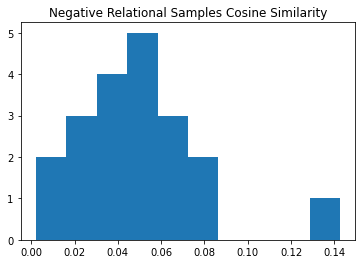

In [ ]:
plt.hist(([neg_rela['rela_sim']]), label = 'relational cosine similarity score')
plt.title('Negative Relational Samples Cosine Similarity')
plt.show()

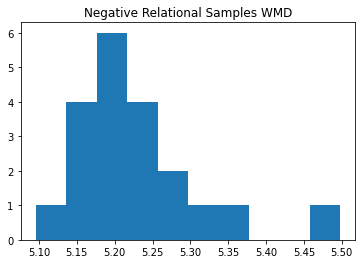

In [ ]:
plt.hist(([neg_rela['rela_scores']]), label = 'relational cosine similarity score')
plt.title('Negative Relational Samples WMD')
plt.show()

**Demographic Samples**

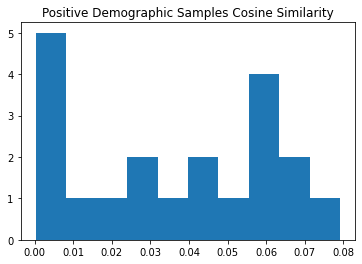

In [ ]:
plt.hist(([pos_demog['dem_sim']]))
plt.title('Positive Demographic Samples Cosine Similarity')
plt.show()

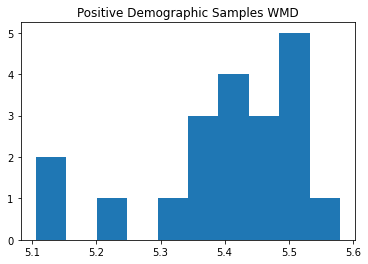

In [ ]:
plt.hist(([pos_demog['dem_scores']]))
plt.title('Positive Demographic Samples WMD')
plt.show()

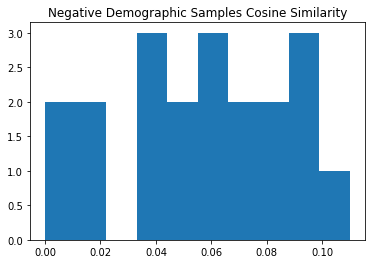

In [ ]:
plt.hist(([neg_demog['dem_sim']]))
plt.title('Negative Demographic Samples Cosine Similarity')
plt.show()

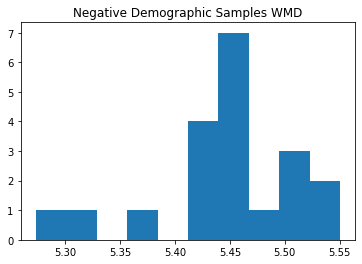

In [ ]:
plt.hist(([neg_demog['dem_scores']]))
plt.title('Negative Demographic Samples WMD')
plt.show()

**Cultural Samples**

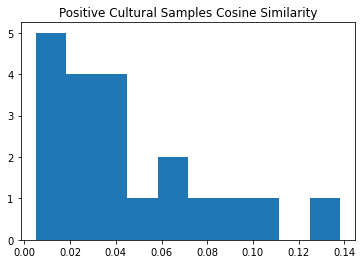

In [ ]:
plt.hist(([pos_cult['cult_sim']]))
plt.title('Positive Cultural Samples Cosine Similarity')
plt.show()

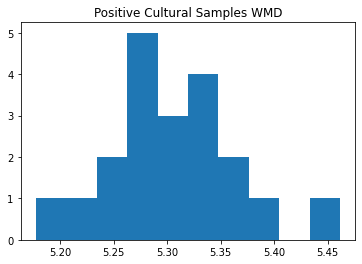

In [ ]:
plt.hist(([pos_cult['cult_scores']]))
plt.title('Positive Cultural Samples WMD')
plt.show()

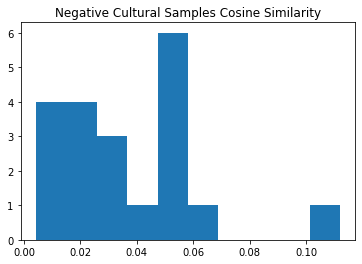

In [ ]:
plt.hist(([neg_cult['cult_sim']]))
plt.title('Negative Cultural Samples Cosine Similarity')
plt.show()

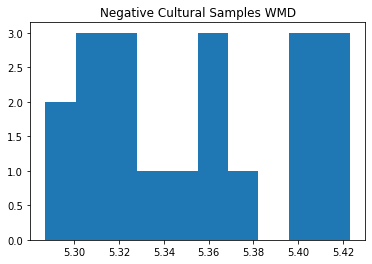

In [ ]:
plt.hist(([neg_cult['cult_scores']]))
plt.title('Negative Cultural Samples WMD')
plt.show()